In [5]:
# --- Импорты ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, average_precision_score
import joblib



# 1️⃣ Загрузка CSV с компьютера
# ------------------------------
from google.colab import files
import pandas as pd

uploaded = files.upload()  # выберите eng_toxic_full_df.csv
filename = list(uploaded.keys())[0]
dataset = pd.read_csv(filename)



Saving eng_toxic_full_df.csv to eng_toxic_full_df (1).csv


In [52]:
# ------------------------------
# 2️⃣ Выбор нужных колонок
# ------------------------------
columns = ['comment_text', 'neutral', 'toxic_not_threat', 'toxic_threat']
dataset = dataset[columns]


In [53]:
# 3️⃣ Oversampling редкого класса (toxic_threat)
neutral_df = dataset[dataset['neutral'] == 1]
toxic_not_threat_df = dataset[dataset['toxic_not_threat'] == 1]
toxic_threat_df = dataset[dataset['toxic_threat'] == 1]

# Увеличиваем количество примеров редкого класса
toxic_threat_oversampled = toxic_threat_df.sample(n=len(neutral_df), replace=True, random_state=42)

# Новый сбалансированный датасет
balanced_dataset = pd.concat([neutral_df, toxic_not_threat_df, toxic_threat_oversampled], axis=0)
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [54]:
# ------------------------------
# 4️⃣ Преобразование меток в числа
# ------------------------------
y = balanced_dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]
y = y.idxmax(axis=1).map({'neutral':0, 'toxic_not_threat':1, 'toxic_threat':2}).values
X = balanced_dataset['comment_text'].values


In [55]:
# 5️⃣ Разделение на train/test
# ------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [56]:
# ------------------------------
# 6️⃣ Преобразование текста в TF-IDF
# ------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [57]:
# 7️⃣ Logistic Regression с усилением веса редкого класса
class_weights_opt = {0:1, 1:2, 2:4}    # сбалансированное усиление
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight=class_weights)
clf.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight={0: 1, 1: 1, 2: 5}, max_iter=1000,
                   multi_class='multinomial')

In [58]:
# 8️⃣ Предсказания и вероятности
# ------------------------------
y_pred = clf.predict(X_test_tfidf)
y_prob = clf.predict_proba(X_test_tfidf)  # вероятности для ROC-AUC и PR-AUC

Accuracy: 0.9731847639201164
Macro F1: 0.8909632172037386
Weighted F1: 0.9706272544947355
Precision per class: [0.96231198 0.89617486 0.98968501]
Recall per class: [0.98950368 0.57746479 1.        ]
ROC-AUC (macro, OvR): 0.988459646994753
PR-AUC per class: [np.float64(0.9950151181255572), np.float64(0.8131773413659923), np.float64(0.9984291272589912)]


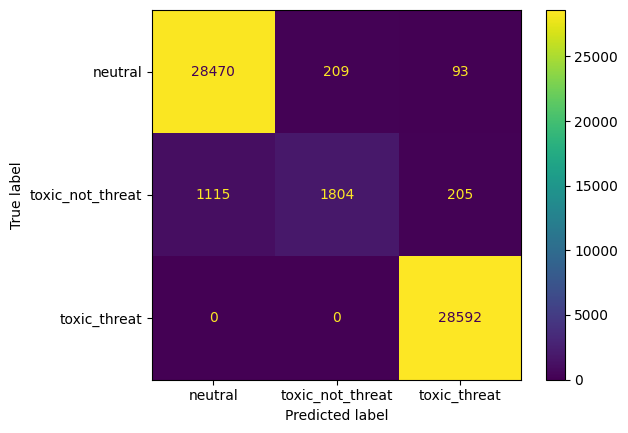

In [59]:
# 9️⃣ Метрики
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_test, y_pred, average='weighted'))
print("Precision per class:", precision_score(y_test, y_pred, average=None))
print("Recall per class:", recall_score(y_test, y_pred, average=None))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['neutral','toxic_not_threat','toxic_threat'])
disp.plot()

# ROC-AUC мультикласс
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0,1,2])
roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
print("ROC-AUC (macro, OvR):", roc_auc)

# PR-AUC по классам
pr_auc_per_class = []
for i in range(3):
    pr = average_precision_score(y_test_bin[:,i], y_prob[:,i])
    pr_auc_per_class.append(pr)
print("PR-AUC per class:", pr_auc_per_class)


✅ Оценка качества логистической регрессии
Модель показывает высокое общее качество, но существенно недообнаруживает токсичные комментарии без угроз.

Сильные стороны:
Почти идеальное распознавание угроз (Recall = 1.0, Precision = 0.99).
Отличная классификация нейтральных текстов (Recall = 0.99, Precision = 0.96).
Высокие агрегированные метрики: Accuracy = 0.973, Weighted F1 = 0.971, ROC-AUC = 0.988.
Критическая слабость:
Recall для класса toxic_not_threat всего 0.58 — модель пропускает 42% токсичных, но не угрожающих сообщений.
Это делает её непригодной для реального применения в модерации, где важно минимизировать ложные негативы (пропущенную токсичность).
Итоговая оценка:
Логистическая регрессия с TF-IDF справляется с крайними классами, но не справляется с семантически нечёткой токсичностью. Качество недостаточно для production, несмотря на высокую accuracy. Требуется доработка (балансировка, настройка порогов, улучшение признаков) или переход к более выразительным моделям.

In [60]:
# ------------------------------
# 🔟 Сохранение модели и TF-IDF
# ------------------------------
import joblib
joblib.dump(clf, "eng_logreg_model.pkl")
joblib.dump(tfidf, "tfidf_eng_vectorizer.pkl")
print("Модель и векторизатор сохранены.")

Модель и векторизатор сохранены.
